<a href="https://colab.research.google.com/github/DonaldTraube/Baseball/blob/main/2022_2024_MLB_Unweighted_WAR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3383543317.py:6: DtypeWarning: Columns (133,140) have mixed types. Specify dtype option on import or set low_memory=False.
  pitching = pd.read_csv('2022_2023_2024_Pitching.csv')
/tmp/ipython-input-3383543317.py:7: DtypeWarning: Columns (136,143,239,240) have mixed types. Specify dtype option on import or set low_memory=False.
  batting = pd.read_csv('2022_2023_2024_Batting.csv')


Pitching columns: ['#', 'Team', 'IP', 'G', 'R', 'WHIP', 'WAR', 'Age', 'W', 'L', 'ERA', 'G.1', 'GS', 'CG', 'ShO', 'SV', 'BS', 'IP.1', 'TBF', 'H', 'R.1', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'GB', 'FB', 'LD', 'IFFB', 'Balls', 'Strikes', 'Pitches', 'RS', 'IFH', 'BU', 'BUH', 'K/9', 'BB/9', 'K/BB', 'H/9', 'HR/9', 'AVG', 'WHIP.1', 'BABIP', 'LOB%', 'FIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'BUH%', 'Starting', 'Start-IP', 'Relieving', 'Relief-IP', 'RAR', 'WAR.1', 'Dollars', 'tERA', 'xFIP', 'WPA', '-WPA', '+WPA', 'RE24', 'REW', 'pLI', 'inLI', 'gmLI', 'exLI', 'Pulls', 'WPA/LI', 'Clutch', 'FB%.1', 'FBv', 'SL%', 'SLv', 'CT%', 'CTv', 'CB%', 'CBv', 'CH%', 'CHv', 'SF%', 'SFv', 'KN%', 'KNv', 'XX%', 'PO%', 'wFB', 'wSL', 'wCT', 'wCB', 'wCH', 'wSF', 'wKN', 'wFB/C', 'wSL/C', 'wCT/C', 'wCB/C', 'wCH/C', 'wSF/C', 'wKN/C', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'HLD', 'SD', 'MD', 'ERA-', 'FIP-', 'xFIP-', 'K%',

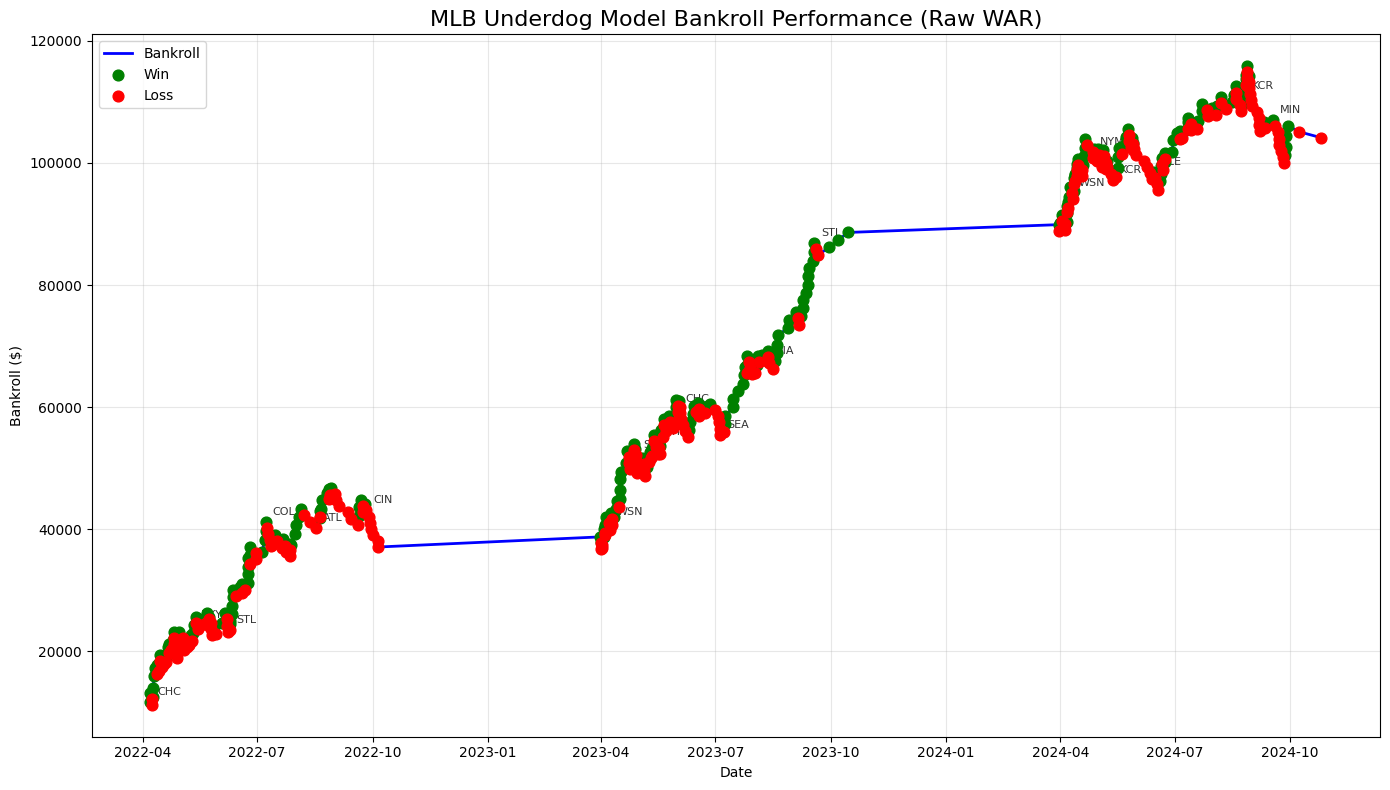


Bankroll performance plot saved as 'bankroll_performance.png'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data (adjust filenames if needed in Colab)
pitching = pd.read_csv('2022_2023_2024_Pitching.csv')
batting = pd.read_csv('2022_2023_2024_Batting.csv')
schedule = pd.read_csv('MLB_Schedule.csv')

# DEBUG: Print columns to identify exact names
print("Pitching columns:", pitching.columns.tolist())
print("Batting columns:", batting.columns.tolist())

# Clean column names (remove leading/trailing spaces)
pitching.columns = pitching.columns.str.strip()
batting.columns = batting.columns.str.strip()
schedule.columns = schedule.columns.str.strip()

# Convert key columns to numeric
pitching['K-BB%'] = pd.to_numeric(pitching['K-BB%'].astype(str).str.replace('%', ''), errors='coerce')
batting['wRC+'] = pd.to_numeric(batting['wRC+'], errors='coerce')
pitching['IP'] = pd.to_numeric(pitching['IP'], errors='coerce')      # Innings Pitched
batting['TG'] = pd.to_numeric(batting['TG'], errors='coerce')       # Team Games
pitching['WAR'] = pd.to_numeric(pitching['WAR'], errors='coerce')
batting['WAR'] = pd.to_numeric(batting['WAR'], errors='coerce')

# Parse dates
pitching['End Date'] = pd.to_datetime(pitching['End Date'])
batting['End Date'] = pd.to_datetime(batting['End Date'])
schedule['date'] = pd.to_datetime(schedule['date'])

# Constants
LEAGUE_RA9 = 4.4
LEAGUE_RSG = 4.4
PYTH_EXP = 1.83
HFA = 0.04  # 4% home field advantage

# Regression coefficients (calibrate these from your prior-year fits if needed)
RA9_INTERCEPT = 8.8
RA9_SLOPE = -0.28
RSG_INTERCEPT = -0.45
RSG_SLOPE = 0.041

# Column names
TEAM_COL = 'Team'
DATE_COL = 'End Date'

def get_snapshot(df, team, game_date):
    mask = (df[TEAM_COL] == team) & (df[DATE_COL] <= game_date)
    if mask.any():
        return df[mask].sort_values(DATE_COL).iloc[-1]
    return None

# Bankroll settings
initial_bankroll = 10000
bankroll = initial_bankroll
bet_size_flat = 1000       # $1,000 flat bet (set to None for 2% percentage sizing)
bet_percent = 0.02         # 2% if using percentage sizing

results = []

for _, game in schedule.iterrows():
    game_date = game['date']
    away = game['away_team']
    home = game['home_team']
    away_ml = game['away_money_line']
    home_ml = game['home_money_line']
    winner = 'home' if game['home_score'] > game['away_score'] else 'away'

    # Snapshots
    away_pit = get_snapshot(pitching, away, game_date)
    home_pit = get_snapshot(pitching, home, game_date)
    away_bat = get_snapshot(batting, away, game_date)
    home_bat = get_snapshot(batting, home, game_date)

    if any(x is None for x in [away_pit, home_pit, away_bat, home_bat]):
        continue

    # Weighting: IP for pitching, TG for batting
    ip_away = away_pit['IP']
    ip_home = home_pit['IP']
    games_away = away_bat['TG']
    games_home = home_bat['TG']

    weight_def_away = ip_away / (ip_away + 50)
    weight_def_home = ip_home / (ip_home + 50)
    weight_off_away = games_away / (games_away + 50)
    weight_off_home = games_home / (games_home + 50)

    # Expected RA/9 (defense)
    exp_ra9_away = weight_def_away * (RA9_INTERCEPT + RA9_SLOPE * away_pit['K-BB%']) + (1 - weight_def_away) * LEAGUE_RA9
    exp_ra9_home = weight_def_home * (RA9_INTERCEPT + RA9_SLOPE * home_pit['K-BB%']) + (1 - weight_def_home) * LEAGUE_RA9

    # Expected RS/game (offense)
    exp_rsg_away = weight_off_away * (RSG_INTERCEPT + RSG_SLOPE * away_bat['wRC+']) + (1 - weight_off_away) * LEAGUE_RSG
    exp_rsg_home = weight_off_home * (RSG_INTERCEPT + RSG_SLOPE * home_bat['wRC+']) + (1 - weight_off_home) * LEAGUE_RSG

    # Pythagorean win %
    win_pct_away = exp_rsg_away**PYTH_EXP / (exp_rsg_away**PYTH_EXP + exp_ra9_home**PYTH_EXP)
    win_pct_home = exp_rsg_home**PYTH_EXP / (exp_rsg_home**PYTH_EXP + exp_ra9_away**PYTH_EXP)

    # Apply HFA
    win_pct_home += HFA * (1 - win_pct_home)
    win_pct_away = 1 - win_pct_home

    # RAW WAR (unpaced cumulative – as we established is better-performing in your backtests)
    total_war_away = away_pit['WAR'] + away_bat['WAR']
    total_war_home = home_pit['WAR'] + home_bat['WAR']

    # Determine dog and +120 filter
    if away_ml > 100 and away_ml >= 120:
        dog = 'away'
        dog_ml = away_ml
        model_prob_dog = win_pct_away
        war_diff_dog = total_war_away - total_war_home
    elif home_ml > 100 and home_ml >= 120:
        dog = 'home'
        dog_ml = home_ml
        model_prob_dog = win_pct_home
        war_diff_dog = total_war_home - total_war_away
    else:
        continue

    implied_prob_dog = 100 / (dog_ml + 100)

    # Bet condition: model edge + RAW WAR agrees
    if model_prob_dog > implied_prob_dog + 0.02 and war_diff_dog > 0:
        if bet_size_flat is not None:
            bet_amount = min(bet_size_flat, bankroll)
        else:
            bet_amount = bankroll * bet_percent

        if bet_amount <= 0:
            break

        bankroll -= bet_amount
        if winner == dog:
            bankroll += bet_amount * (dog_ml / 100 + 1)

        results.append({
            'date': game_date,
            'away_team': away,
            'home_team': home,
            'dog_side': dog,
            'dog_odds': dog_ml,
            'model_prob_dog': round(model_prob_dog, 3),
            'war_diff': round(war_diff_dog, 2),
            'result': 'win' if winner == dog else 'loss',
            'bet_amount': round(bet_amount, 2),
            'bankroll_after': round(bankroll, 2)
        })

# Summary and Plot
if results:
    df_results = pd.DataFrame(results)
    total_bets = len(df_results)
    wins = len(df_results[df_results['result'] == 'win'])
    hit_rate = wins / total_bets if total_bets > 0 else 0
    roi = (bankroll - initial_bankroll) / initial_bankroll * 100

    print(f"Total Bets: {total_bets}")
    print(f"Wins: {wins} | Hit Rate: {hit_rate:.1%}")
    print(f"Final Bankroll: ${bankroll:,.2f}")
    print(f"ROI: {roi:.2f}%")

    # EXPORT TO CSV (optional – comment out if not needed)
    df_results.to_csv('betting_results.csv', index=False)
    print("\nResults exported to 'betting_results.csv'")

    # PLOT: Bankroll Over Time
    plt.figure(figsize=(14, 8))
    plt.plot(df_results['date'], df_results['bankroll_after'],
             label='Bankroll', color='blue', linewidth=2)

    # Color points by result
    win_dates = df_results[df_results['result'] == 'win']['date']
    win_bank = df_results[df_results['result'] == 'win']['bankroll_after']
    loss_dates = df_results[df_results['result'] == 'loss']['date']
    loss_bank = df_results[df_results['result'] == 'loss']['bankroll_after']

    plt.scatter(win_dates, win_bank, color='green', label='Win', s=60, zorder=5)
    plt.scatter(loss_dates, loss_bank, color='red', label='Loss', s=60, zorder=5)

    # Label team abbreviations on ~every 20th bet to avoid clutter
    for i in range(0, len(df_results), max(1, len(df_results)//20)):
        row = df_results.iloc[i]
        team = row['away_team'] if row['dog_side'] == 'away' else row['home_team']
        plt.annotate(team, (row['date'], row['bankroll_after']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

    plt.title('MLB Underdog Model Bankroll Performance (Raw WAR)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Bankroll ($)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plt.savefig('bankroll_performance.png', dpi=300)
    plt.show()

    print("\nBankroll performance plot saved as 'bankroll_performance.png'")
else:
    print("No qualifying bets found – check data alignment, filters, or column names.")